<a href="https://colab.research.google.com/github/VindhyaVenu/TKMCE-ECE-DSP-LAB-EXPERIMENTS-B22ECA70/blob/main/Remote%20Sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 22.2 MB/s eta 0:00:00


In [2]:
import os
import rasterio
import numpy as np
import cv2


from skimage.filters import threshold_otsu
from scipy.stats import ttest_rel

from google.colab import files
from google.colab.patches import cv2_imshow  # Required for image display in Colab

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

from sklearn.model_selection import train_test_split
from scipy.ndimage import median_filter
from skimage.filters import threshold_otsu
from scipy.stats import ttest_rel

In [11]:
# Initialize feature and label storage
all_features = []
all_labels = []

In [4]:
from google.colab import files
uploaded = files.upload()

Saving msg.TIF to msg.TIF
Saving msnir.TIF to msnir.TIF
Saving msr.TIF to msr.TIF
Saving msre.TIF to msre.TIF


In [12]:

# Example for NIR band
with rasterio.open('/content/msnir.TIF') as nir_src:
    nir_band = nir_src.read(1).astype(np.float32) / 65535.0

# Similarly for red, green, and red edge
with rasterio.open('/content/msr.TIF') as red_src:
    red_band = red_src.read(1).astype(np.float32) / 65535.0

with rasterio.open('/content/msg.TIF') as green_src:
    green_band = green_src.read(1).astype(np.float32) / 65535.0

with rasterio.open('/content/msre.TIF') as red_edge_src:
    red_edge_band = red_edge_src.read(1).astype(np.float32) / 65535.0


# 🚀 Compute vegetation indices (without EVI)
NDVI = (nir_band - red_band) / (nir_band + red_band + 1e-5)
GNDVI = (nir_band - green_band) / (nir_band + green_band + 1e-5)
MSAVI = (2 * nir_band + 1 - np.sqrt((2 * nir_band + 1) ** 2 - 8 * (nir_band - red_band))) / 2
REVI = (nir_band - red_edge_band) / (nir_band + red_edge_band + 1e-5)

# 🚀 Build Hybrid Vegetation Index (HVI) without EVI
# Adjusted weights: more weight to NDVI and GNDVI
HVI = 0.4 * NDVI + 0.25 * GNDVI + 0.25 * MSAVI + 0.1 * REVI

HVI = median_filter(HVI, size=3)  # Denoise a little

# 🚀 Thresholding using Otsu's method
threshold = threshold_otsu(HVI)
segmented_mask = HVI > threshold

# 🚀 Extract valid pixel features (only where mask = True)
valid_mask = segmented_mask.flatten()

features = np.column_stack([
    NDVI.flatten(),
    GNDVI.flatten(),
    MSAVI.flatten(),
    REVI.flatten(),
    HVI.flatten()
])

features = features[valid_mask]

# 🚀 Initialize Labels
labels = np.zeros(features.shape[0], dtype=int)

# 🚀 Classify into three classes based on NDVI and GNDVI
# Class 0: Highly healthy (high NDVI and GNDVI)
labels[(features[:, 0] > 0.6) & (features[:, 1] > 0.5)] = 0

# Class 1: Mild stress (moderate NDVI, low GNDVI)
labels[(features[:, 0] > 0.3) & (features[:, 0] <= 0.6) & (features[:, 1] <= 0.5)] = 1

# Class 2: Severe stress (low NDVI)
labels[features[:, 0] <= 0.3] = 2

# 🚀 Stack up all features and labels
all_features.append(features)
all_labels.append(labels)

all_features = np.vstack(all_features)
all_labels = np.concatenate(all_labels)

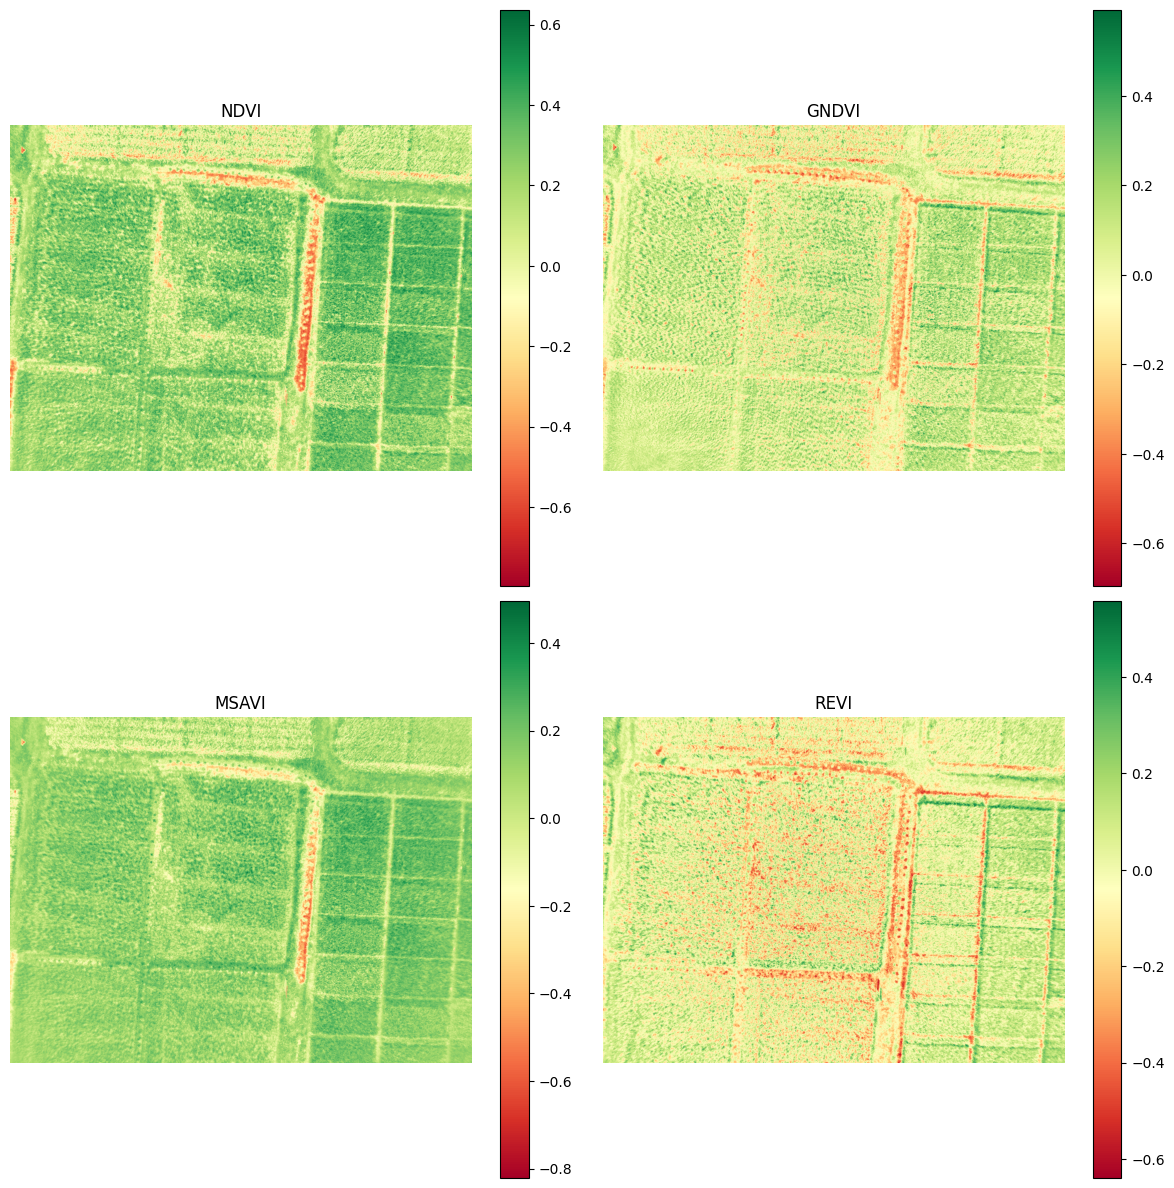

In [14]:
import matplotlib.pyplot as plt

# Create a 2x2 subplot (using all 4 plots now)
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot NDVI
im1 = axes[0, 0].imshow(NDVI, cmap='RdYlGn')
axes[0, 0].set_title('NDVI')
axes[0, 0].axis('off')
fig.colorbar(im1, ax=axes[0, 0])

# Plot GNDVI
im2 = axes[0, 1].imshow(GNDVI, cmap='RdYlGn')
axes[0, 1].set_title('GNDVI')
axes[0, 1].axis('off')
fig.colorbar(im2, ax=axes[0, 1])

# Plot MSAVI
im3 = axes[1, 0].imshow(MSAVI, cmap='RdYlGn')
axes[1, 0].set_title('MSAVI')
axes[1, 0].axis('off')
fig.colorbar(im3, ax=axes[1, 0])

# Plot REVI
im4 = axes[1, 1].imshow(REVI, cmap='RdYlGn')
axes[1, 1].set_title('REVI')
axes[1, 1].axis('off')
fig.colorbar(im4, ax=axes[1, 1])

# Display all
plt.tight_layout()
plt.show()



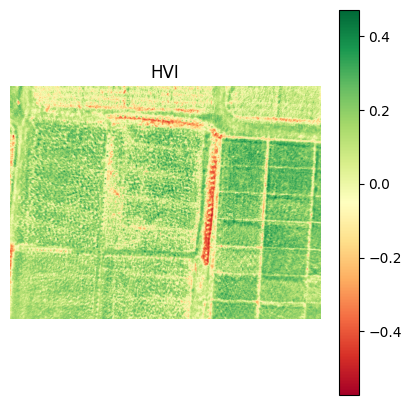

In [15]:
plt.figure(figsize=(5, 5))
im = plt.imshow(HVI, cmap='RdYlGn')
plt.title('HVI')
plt.axis('off')
plt.colorbar(im)
plt.show()

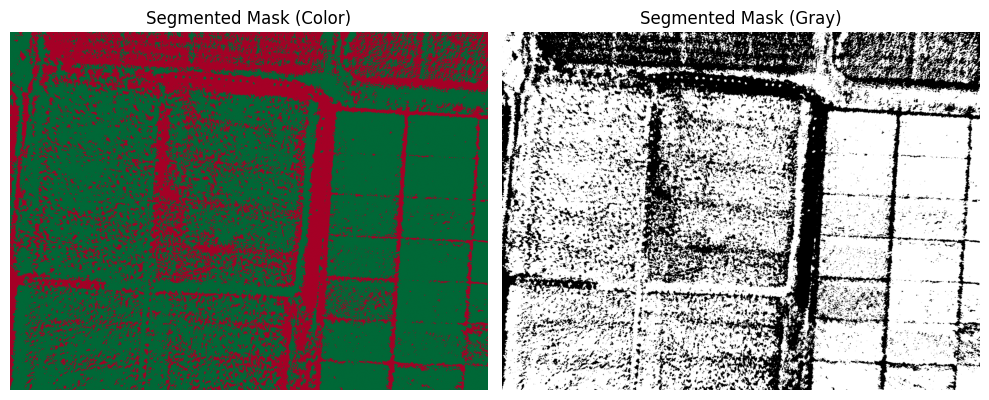

Vegetated Area: 68.89%


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(segmented_mask, cmap='RdYlGn')
axes[0].set_title('Segmented Mask (Color)')
axes[0].axis('off')

axes[1].imshow(segmented_mask, cmap='gray')
axes[1].set_title('Segmented Mask (Gray)')
axes[1].axis('off')

plt.tight_layout()
plt.show()
veg_percentage = np.sum(segmented_mask) / segmented_mask.size * 100
print(f"Vegetated Area: {veg_percentage:.2f}%")


In [26]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    all_features, all_labels, test_size=0.2, random_state=42
)


In [27]:
from google.colab import files
uploaded = files.upload()

Saving rgb.JPG to rgb.JPG


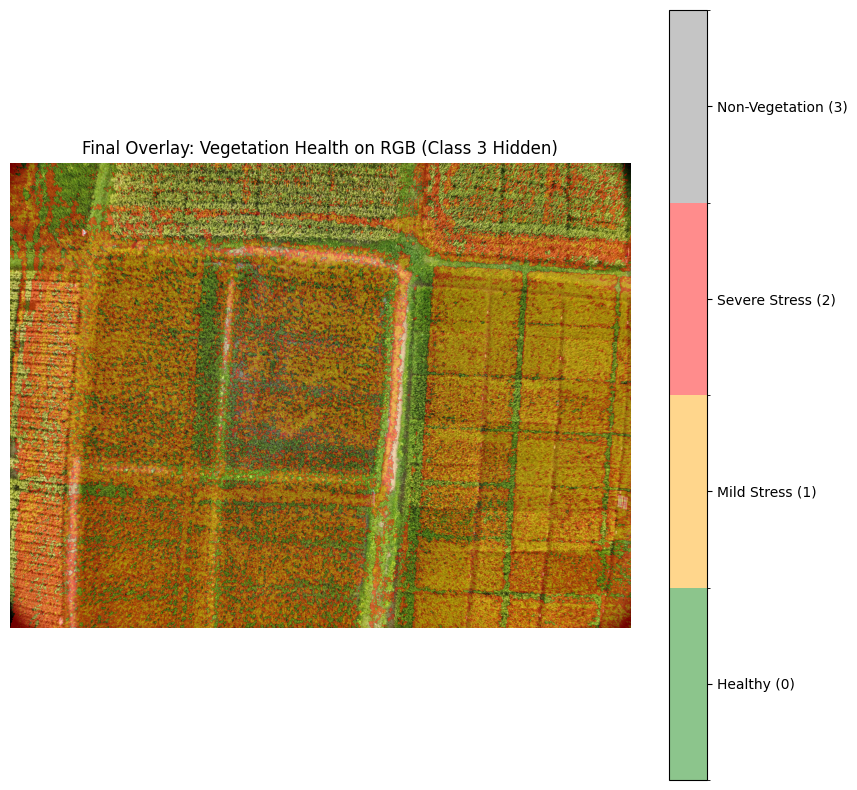

In [28]:
# 🔥 Imports needed now
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from skimage.transform import resize

# 🚀 1. Stack Features
features = np.column_stack([
    nir_band.flatten(),
    red_band.flatten(),
    green_band.flatten(),
    red_edge_band.flatten(),
    NDVI.flatten(),
    GNDVI.flatten(),
    MSAVI.flatten(),
    REVI.flatten(),
    HVI.flatten()
])

valid_mask = segmented_mask.flatten()
features_valid = features[valid_mask]

# 🚀 2. Create Labels
labels = np.zeros(features_valid.shape[0], dtype=int)
labels[(features_valid[:, 4] > 0.6) & (features_valid[:, 5] > 0.5)] = 0
labels[(features_valid[:, 4] > 0.3) & (features_valid[:, 4] <= 0.6) & (features_valid[:, 5] <= 0.5)] = 1
labels[features_valid[:, 4] <= 0.3] = 2

# 🚀 3. Train Random Forest
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_valid)

x_train, x_val, y_train, y_val = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

# 🚀 4. Predict Full Image
all_features_scaled = scaler.transform(features)

full_preds = np.full(all_features_scaled.shape[0], 3)  # Default to Non-Vegetation
full_preds[valid_mask] = rf_model.predict(features_scaled)

label_map = full_preds.reshape(nir_band.shape)

# 🚀 5. Overlay on RGB
rgb_image = np.array(Image.open('/content/rgb.JPG'))

# Resize if needed
if rgb_image.shape[:2] != label_map.shape:
    rgb_image = resize(rgb_image, label_map.shape, preserve_range=True, anti_aliasing=True).astype(np.uint8)

colors = ['green', 'orange', 'red', 'gray']
cmap = ListedColormap(colors)
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, cmap.N)

masked_label_map = np.ma.masked_where(label_map == 3, label_map)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.imshow(masked_label_map, cmap=cmap, norm=norm, alpha=0.45)
plt.title("Final Overlay: Vegetation Health on RGB (Class 3 Hidden)")
plt.axis('off')

cbar = plt.colorbar(ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(['Healthy (0)', 'Mild Stress (1)', 'Severe Stress (2)', 'Non-Vegetation (3)'])
plt.show()


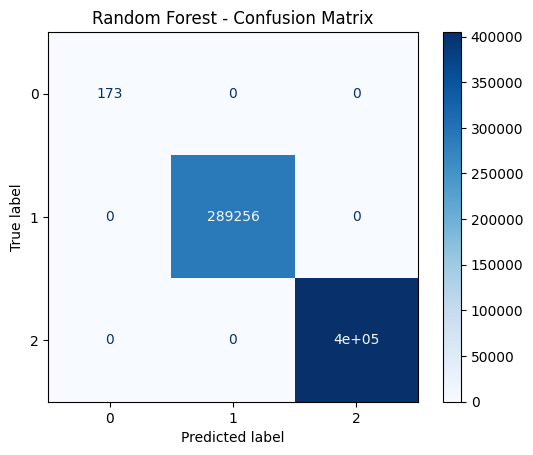

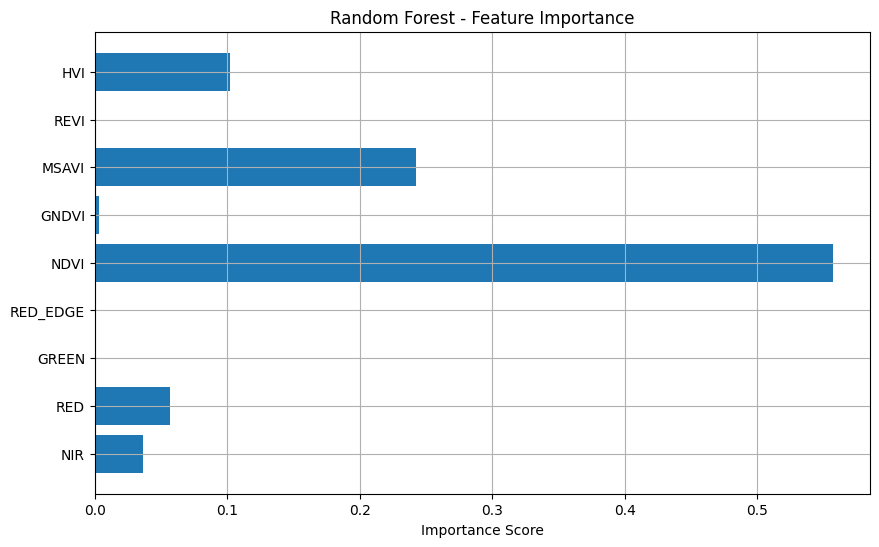

Validation Accuracy (Random Forest): 1.0000


In [31]:
# 📊 Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_val_pred = rf_model.predict(x_val)
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.show()

# 📈 Feature Importance Plot
importances = rf_model.feature_importances_
feature_names = ['NIR', 'RED', 'GREEN', 'RED_EDGE', 'NDVI', 'GNDVI', 'MSAVI', 'REVI', 'HVI']

plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.xlabel('Importance Score')
plt.title('Random Forest - Feature Importance')
plt.grid(True)
plt.show()

# ✅ Final Validation Accuracy
from sklearn.metrics import accuracy_score
final_val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy (Random Forest): {final_val_accuracy:.4f}")


In [34]:
from scipy.ndimage import median_filter
from skimage.filters import threshold_otsu
import numpy as np

# 1. Load full bands (already loaded as nir_band, red_band, green_band, red_edge_band)
nir = nir_band
red = red_band
green = green_band
red_edge = red_edge_band

# 2. Compute indices
NDVI = (nir - red) / (nir + red + 1e-8)
GNDVI = (nir - green) / (nir + green + 1e-8)
MSAVI = (2 * nir + 1 - np.sqrt((2 * nir + 1)**2 - 8 * (nir - red))) / 2
REVI = (nir - red_edge) / (nir + red_edge + 1e-8)
HVI = 0.4 * NDVI + 0.25 * GNDVI + 0.25 * MSAVI + 0.1 * REVI
HVI = median_filter(HVI, size=3)

# 3. Segment vegetation using Otsu threshold
threshold = threshold_otsu(HVI)
segmented_mask = HVI > threshold
flat_mask = segmented_mask.flatten()

# 4. Stack full features
all_features = np.column_stack([
    nir.flatten(),
    red.flatten(),
    green.flatten(),
    red_edge.flatten(),
    NDVI.flatten(),
    GNDVI.flatten(),
    MSAVI.flatten(),
    REVI.flatten(),
    HVI.flatten()
])

masked_features = all_features[flat_mask]

# 5. Scale & Predict
masked_features_scaled = scaler.transform(masked_features)
full_predictions = np.full(NDVI.size, 3)  # default class = 3 (non-veg)
full_predictions[flat_mask] = rf_model.predict(masked_features_scaled)
label_map = full_predictions.reshape(NDVI.shape)

print("Class distribution:", np.bincount(label_map.flatten().astype(int)))


Class distribution: [      0 2649811  821362 1567675]


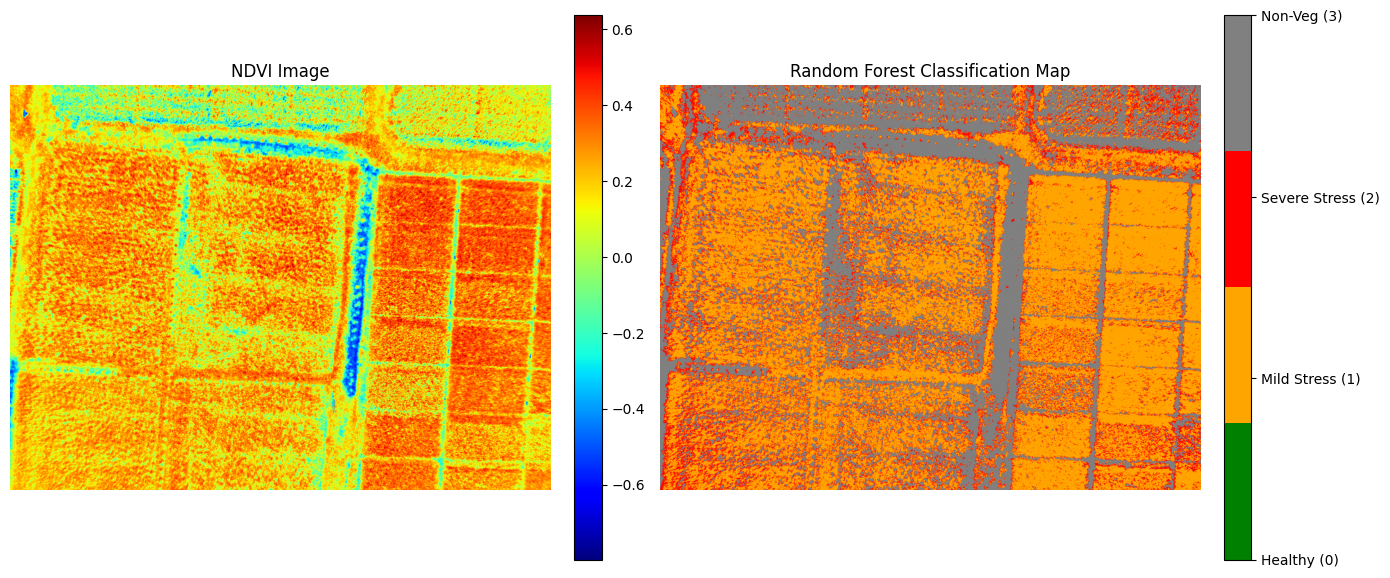

In [36]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define colormap for classification map
colors = ['green', 'orange', 'red', 'gray']  # 0 = Healthy, 1 = Mild Stress, 2 = Severe Stress, 3 = Non-Veg
cmap = ListedColormap(colors)

# Plot NDVI and classification map side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. NDVI Plot
im1 = axes[0].imshow(NDVI, cmap='jet')
axes[0].set_title("NDVI Image")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# 2. Classification Map Plot
im2 = axes[1].imshow(label_map, cmap=cmap, vmin=0, vmax=3)
axes[1].set_title("Random Forest Classification Map")
axes[1].axis('off')
cbar = fig.colorbar(im2, ax=axes[1], ticks=[0, 1, 2, 3], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(['Healthy (0)', 'Mild Stress (1)', 'Severe Stress (2)', 'Non-Veg (3)'])

plt.tight_layout()
plt.show()



MODEL ON HVI

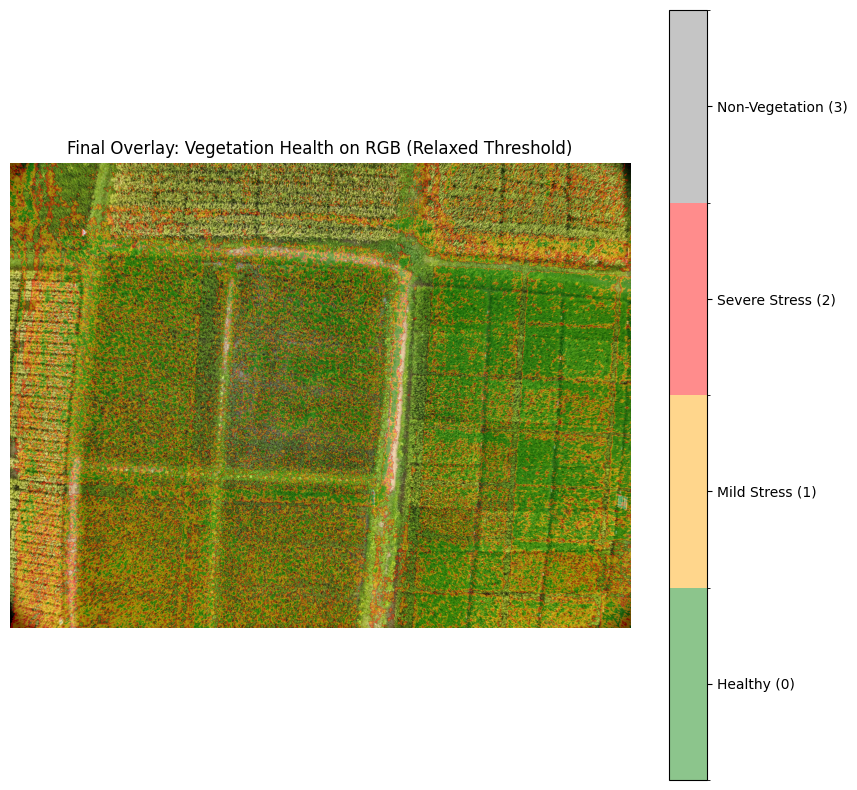

In [109]:
# 🔥 Imports needed now
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from skimage.transform import resize

# 🚀 1. Stack Features
features = np.column_stack([
    nir_band.flatten(),
    red_band.flatten(),
    green_band.flatten(),
    red_edge_band.flatten(),
    NDVI.flatten(),
    GNDVI.flatten(),
    MSAVI.flatten(),
    REVI.flatten(),
    HVI.flatten()
])

valid_mask = segmented_mask.flatten()
features_valid = features[valid_mask]

# 🚀 2. Create Labels with relaxed thresholding
# Use HVI for health classification
hvi_flat = features_valid[:, 8]
labels[hvi_flat > 0.2085] = 0  # perfect Health
labels[((hvi_flat >= .133) & (hvi_flat <= 0.2085))] = 1  # Moderate health(mild stress)
labels[(hvi_flat < 0.133) ] = 2  # Severe Stress


# 🚀 3. Train Random Forest
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_valid)

x_train, x_val, y_train, y_val = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

# 🚀 4. Predict Full Image
all_features_scaled = scaler.transform(features)
full_preds = np.full(all_features_scaled.shape[0], 3)  # Default to Non-Vegetation
full_preds[valid_mask] = rf_model.predict(features_scaled)
label_map = full_preds.reshape(nir_band.shape)

# 🚀 5. Overlay on RGB
rgb_image = np.array(Image.open('/content/rgb.JPG'))

# Resize if needed
if rgb_image.shape[:2] != label_map.shape:
    rgb_image = resize(rgb_image, label_map.shape, preserve_range=True, anti_aliasing=True).astype(np.uint8)

# Define colors and plot
colors = ['green', 'orange', 'red', 'gray']
cmap = ListedColormap(colors)
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, cmap.N)

masked_label_map = np.ma.masked_where(label_map == 3, label_map)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.imshow(masked_label_map, cmap=cmap, norm=norm, alpha=0.45)
plt.title("Final Overlay: Vegetation Health on RGB (Relaxed Threshold)")
plt.axis('off')

cbar = plt.colorbar(ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(['Healthy (0)', 'Mild Stress (1)', 'Severe Stress (2)', 'Non-Vegetation (3)'])
plt.show()


In [110]:
counts = np.bincount(label_map.flatten().astype(int), minlength=4)
total = label_map.size

for u, c in enumerate(counts):
    print(f"Class {u}: {c} pixels ({(c / total) * 100:.2f}%)")

Class 0: 1259952 pixels (25.00%)
Class 1: 1326333 pixels (26.32%)
Class 2: 884888 pixels (17.56%)
Class 3: 1567675 pixels (31.11%)


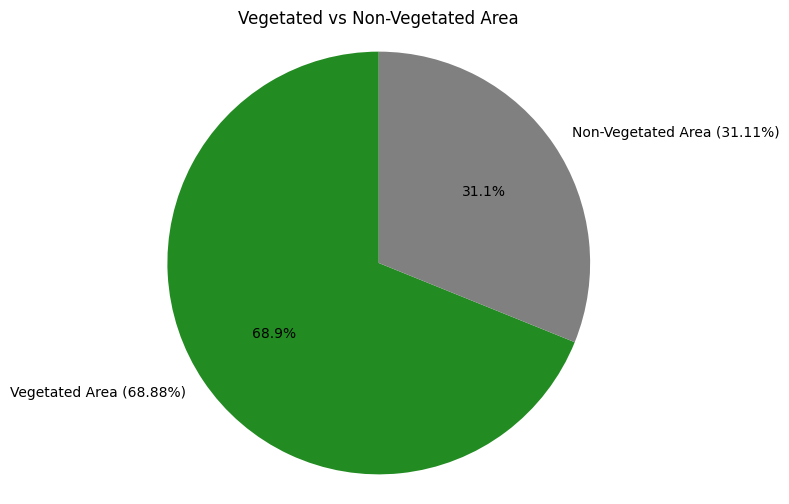

In [119]:
import matplotlib.pyplot as plt

# Percentages from your data
labels = ['Vegetated Area', 'Non-Vegetated Area']
sizes = [25.00 + 26.32 + 17.56, 31.11]  # Vegetated = sum of class 0,1,2
colors = ['forestgreen', 'gray']
explode = [0.05, 0.05]

# Plot
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=[f'{l} ({s:.2f}%)' for l, s in zip(labels, sizes)],
    colors=colors,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Vegetated vs Non-Vegetated Area')
plt.axis('equal')
plt.show()


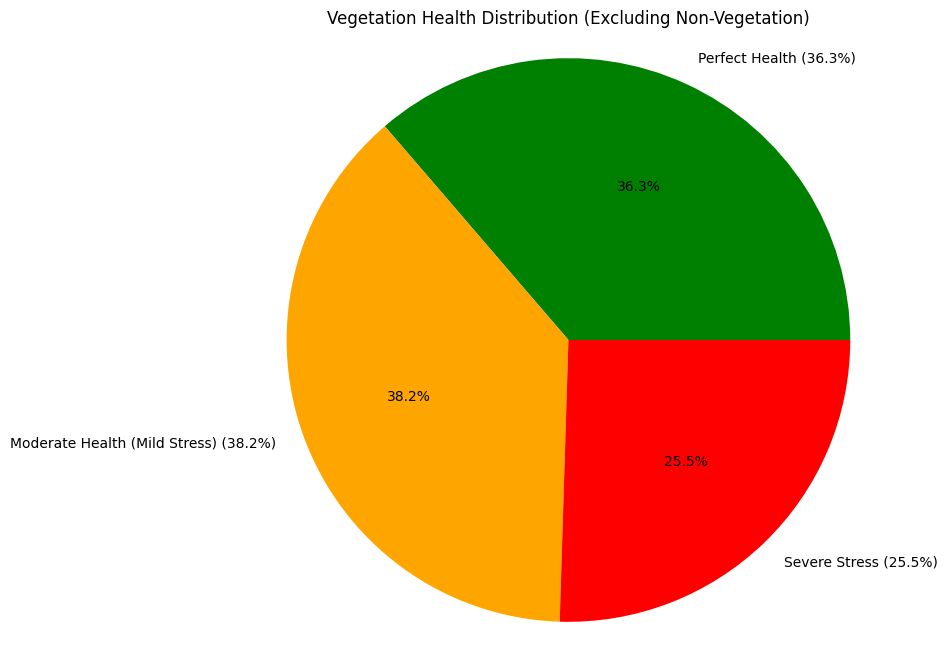

In [120]:
import matplotlib.pyplot as plt

# Class pixel counts for Class 0, 1, 2
sizes = [1259952, 1326333, 884888]
total = sum(sizes)
labels = ['Perfect Health', 'Moderate Health (Mild Stress)', 'Severe Stress']
colors = ['green', 'orange', 'red']
percent = [x / total * 100 for x in sizes]

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    percent,
    labels=[f'{l} ({p:.1f}%)' for l, p in zip(labels, percent)],
    colors=colors,
    autopct='%1.1f%%',
    startangle=0,

)
plt.title('Vegetation Health Distribution (Excluding Non-Vegetation)')
plt.axis('equal')  # Keep it a perfect circle
plt.show()


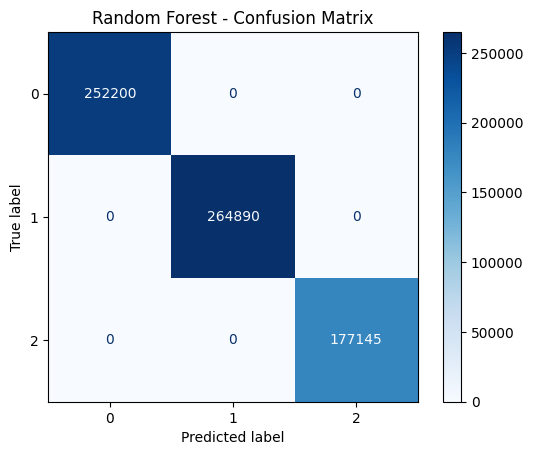

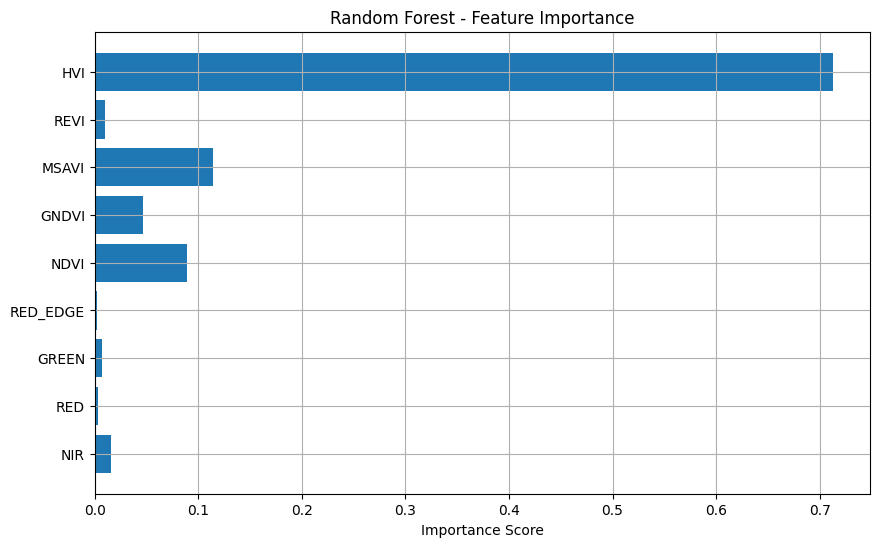

Validation Accuracy (Random Forest): 1.0000


In [121]:
# 📊 Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_val_pred = rf_model.predict(x_val)
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.show()

# 📈 Feature Importance Plot
importances = rf_model.feature_importances_
feature_names = ['NIR', 'RED', 'GREEN', 'RED_EDGE', 'NDVI', 'GNDVI', 'MSAVI', 'REVI', 'HVI']

plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.xlabel('Importance Score')
plt.title('Random Forest - Feature Importance')
plt.grid(True)
plt.show()

# ✅ Final Validation Accuracy
from sklearn.metrics import accuracy_score
final_val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy (Random Forest): {final_val_accuracy:.4f}")

In [122]:
from scipy.ndimage import median_filter
from skimage.filters import threshold_otsu
import numpy as np

# 1. Load full bands (already loaded as nir_band, red_band, green_band, red_edge_band)
nir = nir_band
red = red_band
green = green_band
red_edge = red_edge_band

# 2. Compute indices
NDVI = (nir - red) / (nir + red + 1e-8)
GNDVI = (nir - green) / (nir + green + 1e-8)
MSAVI = (2 * nir + 1 - np.sqrt((2 * nir + 1)**2 - 8 * (nir - red))) / 2
REVI = (nir - red_edge) / (nir + red_edge + 1e-8)
HVI = 0.4 * NDVI + 0.25 * GNDVI + 0.25 * MSAVI + 0.1 * REVI
HVI = median_filter(HVI, size=3)

# 3. Segment vegetation using Otsu threshold
threshold = threshold_otsu(HVI)
segmented_mask = HVI > threshold
flat_mask = segmented_mask.flatten()

# 4. Stack full features
all_features = np.column_stack([
    nir.flatten(),
    red.flatten(),
    green.flatten(),
    red_edge.flatten(),
    NDVI.flatten(),
    GNDVI.flatten(),
    MSAVI.flatten(),
    REVI.flatten(),
    HVI.flatten()
])

masked_features = all_features[flat_mask]

# 5. Scale & Predict
masked_features_scaled = scaler.transform(masked_features)
full_predictions = np.full(NDVI.size, 3)  # default class = 3 (non-veg)
full_predictions[flat_mask] = rf_model.predict(masked_features_scaled)
label_map = full_predictions.reshape(NDVI.shape)

print("Class distribution:", np.bincount(label_map.flatten().astype(int)))

Class distribution: [1259952 1326333  884888 1567675]


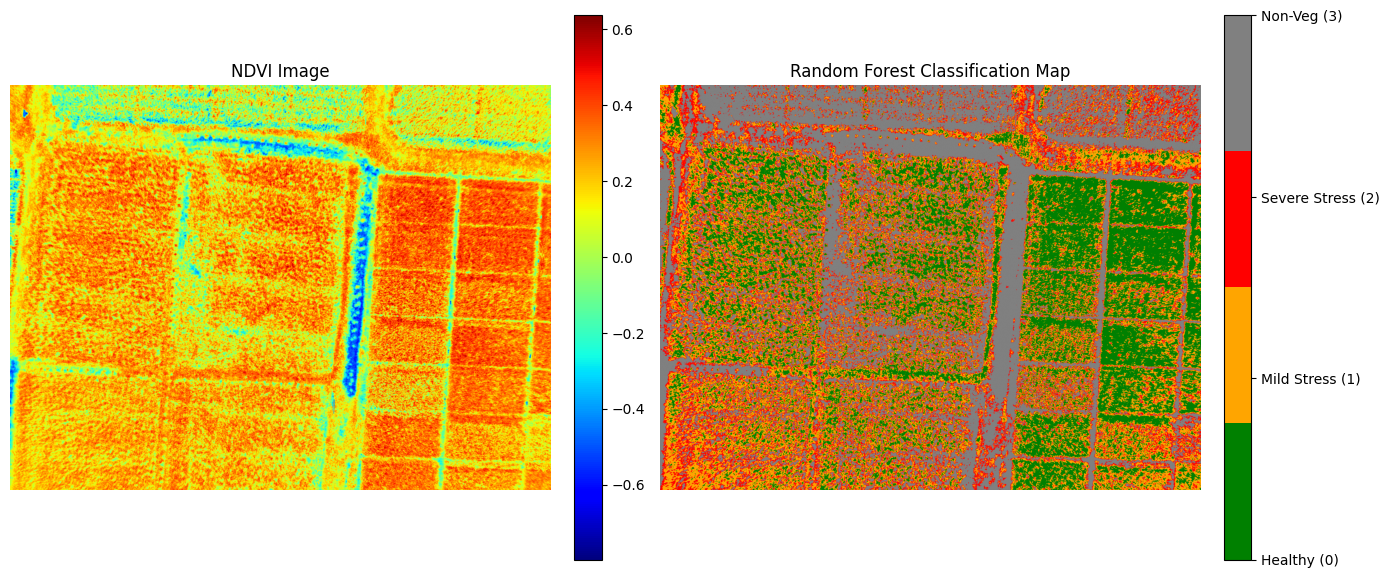

In [123]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define colormap for classification map
colors = ['green', 'orange', 'red', 'gray']  # 0 = Healthy, 1 = Mild Stress, 2 = Severe Stress, 3 = Non-Veg
cmap = ListedColormap(colors)

# Plot NDVI and classification map side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. NDVI Plot
im1 = axes[0].imshow(NDVI, cmap='jet')
axes[0].set_title("NDVI Image")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# 2. Classification Map Plot
im2 = axes[1].imshow(label_map, cmap=cmap, vmin=0, vmax=3)
axes[1].set_title("Random Forest Classification Map")
axes[1].axis('off')
cbar = fig.colorbar(im2, ax=axes[1], ticks=[0, 1, 2, 3], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(['Healthy (0)', 'Mild Stress (1)', 'Severe Stress (2)', 'Non-Veg (3)'])

plt.tight_layout()
plt.show()